# Building Stock Trading RL Environment

- Building a stock market trading RL platform using real stock exchange data
- Building a stock market trading RL platform using price charts
- Building an advanced stock trading RL platform to train agents to mimic professional traders

## Imports

In [ ]:
!pip install mplfinance

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from matplotlib import style
from mplfinance.original_flavor import candlestick_ohlc

import os
import cv2
import random
from typing import Dict
import gym
from gym import spaces

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)

## Data

In [ ]:
!wget -q --show-progress https://github.com/sparsh-ai/stanza/raw/S990517/data/MSFT.csv
!wget -q --show-progress https://github.com/sparsh-ai/stanza/raw/S990517/data/TSLA.csv

MSFT.csv            100%[===================>]  88.81K  --.-KB/s    in 0.01s   
TSLA.csv            100%[===================>]  86.93K  --.-KB/s    in 0.01s   


## Utils

In [ ]:
class TradeVisualizer(object):
    """Visualizer for stock trades"""

    def __init__(self, ticker, ticker_data_stream, title=None, skiprows=0):
        self.ticker = ticker
        # Stock/crypto market/exchange data stream. An offline file stream is used.
        # Alternatively, a web
        # API can be used to pull live data.
        self.ohlcv_df = pd.read_csv(
            ticker_data_stream, parse_dates=True, index_col="Date", skiprows=skiprows
        ).sort_values(by="Date")
        if "USD" in self.ticker:  # True for crypto-fiat currency pairs
            # Use volume of the crypto currency for volume plot.
            # A column with header="Volume" is required for default mpf plot.
            # Remove "USD" from self.ticker string and clone the crypto volume column
            self.ohlcv_df["Volume"] = self.ohlcv_df[
                "Volume " + self.ticker[:-3]  # e.g: "Volume BTC"
            ]
        self.account_balances = np.zeros(len(self.ohlcv_df.index))

        fig = plt.figure("TFRL-Cookbook", figsize=[12, 6])
        fig.suptitle(title)
        nrows, ncols = 6, 1
        gs = fig.add_gridspec(nrows, ncols)
        row, col = 0, 0
        rowspan, colspan = 2, 1

        # self.account_balance_ax = plt.subplot2grid((6, 1), (0, 0), rowspan=2, colspan=1)
        self.account_balance_ax = fig.add_subplot(
            gs[row : row + rowspan, col : col + colspan]
        )
        row, col = 2, 0
        rowspan, colspan = 8, 1

        self.price_ax = plt.subplot2grid(
            (nrows, ncols),
            (row, col),
            rowspan=rowspan,
            colspan=colspan,
            sharex=self.account_balance_ax,
        )
        self.price_ax = fig.add_subplot(gs[row : row + rowspan, col : col + colspan])

        plt.show(block=False)
        self.viz_not_initialized = True

    def _render_account_balance(self, current_step, account_balance, horizon):
        self.account_balance_ax.clear()
        date_range = self.ohlcv_df.index[current_step : current_step + len(horizon)]

        self.account_balance_ax.plot_date(
            date_range,
            self.account_balances[horizon],
            "-",
            label="Account Balance ($)",
            lw=1.0,
        )

        self.account_balance_ax.legend()
        legend = self.account_balance_ax.legend(loc=2, ncol=2)
        legend.get_frame().set_alpha(0.4)

        last_date = self.ohlcv_df.index[current_step + len(horizon)].strftime(
            "%Y-%m-%d"
        )
        last_date = matplotlib.dates.datestr2num(last_date)
        last_account_balance = self.account_balances[current_step]

        self.account_balance_ax.annotate(
            "{0:.2f}".format(account_balance),
            (last_date, last_account_balance),
            xytext=(last_date, last_account_balance),
            bbox=dict(boxstyle="round", fc="w", ec="k", lw=1),
            color="black",
        )

        self.account_balance_ax.set_ylim(
            min(self.account_balances[np.nonzero(self.account_balances)]) / 1.25,
            max(self.account_balances) * 1.25,
        )

        plt.setp(self.account_balance_ax.get_xticklabels(), visible=False)

    def render_image_observation(self, current_step, horizon):
        window_start = max(current_step - horizon, 0)
        step_range = range(window_start, current_step + 1)
        date_range = self.ohlcv_df.index[current_step : current_step + len(step_range)]
        stock_df = self.ohlcv_df[self.ohlcv_df.index.isin(date_range)]

        if self.viz_not_initialized:
            self.fig, self.axes = mpf.plot(
                stock_df,
                volume=True,
                type="candle",
                mav=2,
                block=False,
                returnfig=True,
                style="charles",
                tight_layout=True,
            )
            self.viz_not_initialized = False
        else:
            self.axes[0].clear()
            self.axes[2].clear()
            mpf.plot(
                stock_df,
                ax=self.axes[0],
                volume=self.axes[2],
                type="candle",
                mav=2,
                style="charles",
                block=False,
                tight_layout=True,
            )
        self.fig.canvas.set_window_title("TFRL-Cookbook")
        self.fig.canvas.draw()
        fig_data = np.frombuffer(self.fig.canvas.tostring_rgb(), dtype=np.uint8)
        fig_data = fig_data.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))

        self.fig.set_size_inches(12, 6, forward=True)
        self.axes[0].set_ylabel("Price ($)")
        self.axes[0].yaxis.set_label_position("left")
        self.axes[2].yaxis.set_label_position("left")  # Volume

        return fig_data

    def _render_ohlc(self, current_step, dates, horizon):
        self.price_ax.clear()

        candlesticks = zip(
            dates,
            self.ohlcv_df["Open"].values[horizon],
            self.ohlcv_df["Close"].values[horizon],
            self.ohlcv_df["High"].values[horizon],
            self.ohlcv_df["Low"].values[horizon],
        )

        candlestick_ohlc(
            self.price_ax,
            candlesticks,
            width=np.timedelta64(1, "D"),
            colorup="g",
            colordown="r",
        )
        self.price_ax.set_ylabel(f"{self.ticker} Price ($)")
        self.price_ax.tick_params(axis="y", pad=30)

        last_date = self.ohlcv_df.index[current_step].strftime("%Y-%m-%d")
        last_date = matplotlib.dates.datestr2num(last_date)
        last_close = self.ohlcv_df["Close"].values[current_step]
        last_high = self.ohlcv_df["High"].values[current_step]

        self.price_ax.annotate(
            "{0:.2f}".format(last_close),
            (last_date, last_close),
            xytext=(last_date, last_high),
            bbox=dict(boxstyle="round", fc="w", ec="k", lw=1),
            color="black",
        )

        plt.setp(self.price_ax.get_xticklabels(), visible=False)

    def _render_trades(self, trades, horizon):
        for trade in trades:
            if trade["step"] in horizon:
                date = self.ohlcv_df.index[trade["step"]].strftime("%Y-%m-%d")
                date = matplotlib.dates.datestr2num(date)
                high = self.ohlcv_df["High"].values[trade["step"]]
                low = self.ohlcv_df["Low"].values[trade["step"]]

                if trade["type"] == "buy":
                    high_low = low
                    color = "g"
                    arrow_style = "<|-"
                else:  # sell
                    high_low = high
                    color = "r"
                    arrow_style = "-|>"

                proceeds = "{0:.2f}".format(trade["proceeds"])

                self.price_ax.annotate(
                    f"{trade['type']} ${proceeds}".upper(),
                    (date, high_low),
                    xytext=(date, high_low),
                    color=color,
                    arrowprops=(
                        dict(
                            color=color,
                            arrowstyle=arrow_style,
                            connectionstyle="angle3",
                        )
                    ),
                )

    def render(self, current_step, account_balance, trades, window_size=100):
        self.account_balances[current_step] = account_balance

        window_start = max(current_step - window_size, 0)
        step_range = range(window_start, current_step + 1)

        dates = self.ohlcv_df.index[step_range]

        self._render_account_balance(current_step, account_balance, step_range)
        self._render_ohlc(current_step, dates, step_range)
        self._render_trades(trades, step_range)
        """
        self.price_ax.set_xticklabels(
            self.ohlcv_df.index[step_range], rotation=45, horizontalalignment="right",
        )
        """

        plt.grid()
        plt.pause(0.001)

    def close(self):
        plt.close()

## Environments

### Stock trading RL environment with real data from stock exchange

In [ ]:
env_config = {
    "ticker": "TSLA",
    "opening_account_balance": 1000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "order_size": 1,  # Number of shares to buy per buy/sell order
    "data_dir": '/content',
}

In [ ]:
class StockTradingEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Stock trading environment for RL agents
        The observations are stock price info (OHLCV) over a horizon as specified
        in env_config. Action space is discrete to perform buy/sell/hold trades.
        Args:
            ticker (str, optional): Ticker symbol for the stock. Defaults to "MSFT".
            env_config (Dict): Env configuration values
        """
        super(StockTradingEnv, self).__init__()
        self.ticker = env_config.get("ticker", "MSFT")
        data_dir = env_config["data_dir"]
        self.ticker_file_stream = os.path.join(f"{data_dir}", f"{self.ticker}.csv")
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Historical stock data file stream not found at: data/{self.ticker}.csv"
        # Stock market data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        # Data-Frame: Date Open High Low Close Adj-Close Volume
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream)

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 0-> Hold; 1-> Buy; 2 ->Sell;
        self.action_space = spaces.Discrete(3)

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
        ]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(len(self.observation_features), self.horizon + 1),
            dtype=np.float,
        )
        self.order_size = env_config.get("order_size")
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the trading environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_shares_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-StockTradingEnv",
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        # Get stock price info data table from input (file/live) stream
        observation = (
            self.ohlcv_df.loc[
                self.current_step : self.current_step + self.horizon,
                self.observation_features,
            ]
            .to_numpy()
            .T
        )
        return observation

    def execute_trade_action(self, action):
        if action == 0:  # Hold position
            return
        order_type = "buy" if action == 1 else "sell"

        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_shares = int(self.cash_balance / current_price)
            if allowable_shares < self.order_size:
                # Not enough cash to execute a buy order
                return
            # Simulate a BUY order and execute it at current_price
            num_shares_bought = self.order_size
            current_cost = self.cost_basis * self.num_shares_held
            additional_cost = num_shares_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_shares_held + num_shares_bought
            )
            self.num_shares_held += num_shares_bought

            self.trades.append(
                {
                    "type": "buy",
                    "step": self.current_step,
                    "shares": num_shares_bought,
                    "proceeds": additional_cost,
                }
            )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            if self.num_shares_held < self.order_size:
                # Not enough shares to execute a sell order
                return
            num_shares_sold = self.order_size
            self.cash_balance += num_shares_sold * current_price
            self.num_shares_held -= num_shares_sold
            sale_proceeds = num_shares_sold * current_price

            self.trades.append(
                {
                    "type": "sell",
                    "step": self.current_step,
                    "shares": num_shares_sold,
                    "proceeds": sale_proceeds,
                }
            )
        if self.num_shares_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_shares_held * current_price

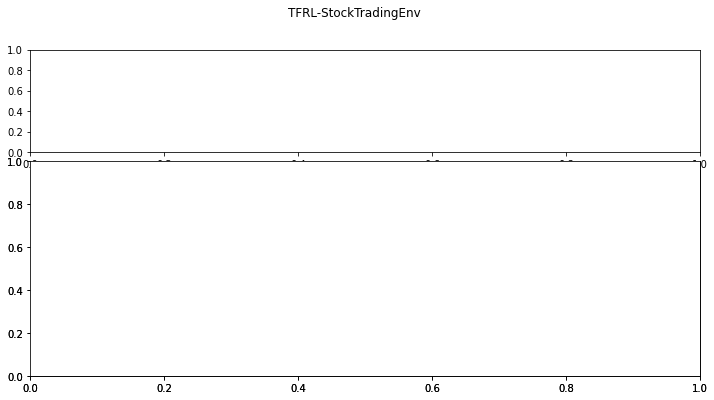

In [ ]:
if __name__ == "__main__":
    env = StockTradingEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()

### Stock/share trading RL environment with continuous-valued trade actions

In [ ]:
env_config = {
    "ticker": "TSLA",
    "opening_account_balance": 1000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "order_size": 1,  # Number of shares to buy per buy/sell order
    "data_dir": '/content'
}

In [ ]:
class StockTradingContinuousEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Stock trading environment for RL agents
        The observations are stock price info (OHLCV) over a horizon as specified
        in env_config. Action space is discrete to perform buy/sell/hold trades.
        Args:
            ticker (str, optional): Ticker symbol for the stock. Defaults to "MSFT".
            env_config (Dict): Env configuration values
        """
        super(StockTradingContinuousEnv, self).__init__()
        self.ticker = env_config.get("ticker", "MSFT")
        data_dir = env_config["data_dir"]
        self.ticker_file_stream = os.path.join(f"{data_dir}", f"{self.ticker}.csv")
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Historical stock data file stream not found at: data/{self.ticker}.csv"
        # Stock market data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        # Data-Frame: Date Open High Low Close Adj-Close Volume
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream)

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 1-dim value indicating a fraction amount of shares to Buy (0 to 1) or
        # sell (-1 to 0). The fraction is taken on the allowable number of
        # shares that can be bought or sold based on the account balance (no margin).
        self.action_space = spaces.Box(
            low=np.array([-1]), high=np.array([1]), dtype=np.float
        )

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
        ]
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(len(self.observation_features), self.horizon + 1),
            dtype=np.float,
        )
        self.order_size = env_config.get("order_size")
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the trading environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step * self.horizon >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_shares_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-StockTradingEnv",
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        # Get stock price info data table from input (file/live) stream
        observation = (
            self.ohlcv_df.loc[
                self.current_step : self.current_step + self.horizon,
                self.observation_features,
            ]
            .to_numpy()
            .T
        )
        return observation

    def execute_trade_action(self, action):

        if action == 0:  # Indicates "Hold" action
            # Hold position; No trade to be executed
            return

        order_type = "buy" if action > 0 else "sell"

        order_fraction_of_allowable_shares = abs(action)
        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_shares = int(self.cash_balance / current_price)
            # Simulate a BUY order and execute it at current_price
            num_shares_bought = int(
                allowable_shares * order_fraction_of_allowable_shares
            )
            current_cost = self.cost_basis * self.num_shares_held
            additional_cost = num_shares_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_shares_held + num_shares_bought
            )
            self.num_shares_held += num_shares_bought

            if num_shares_bought > 0:
                self.trades.append(
                    {
                        "type": "buy",
                        "step": self.current_step,
                        "shares": num_shares_bought,
                        "proceeds": additional_cost,
                    }
                )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            num_shares_sold = int(
                self.num_shares_held * order_fraction_of_allowable_shares
            )
            self.cash_balance += num_shares_sold * current_price
            self.num_shares_held -= num_shares_sold
            sale_proceeds = num_shares_sold * current_price

            if num_shares_sold > 0:
                self.trades.append(
                    {
                        "type": "sell",
                        "step": self.current_step,
                        "shares": num_shares_sold,
                        "proceeds": sale_proceeds,
                    }
                )
        if self.num_shares_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_shares_held * current_price

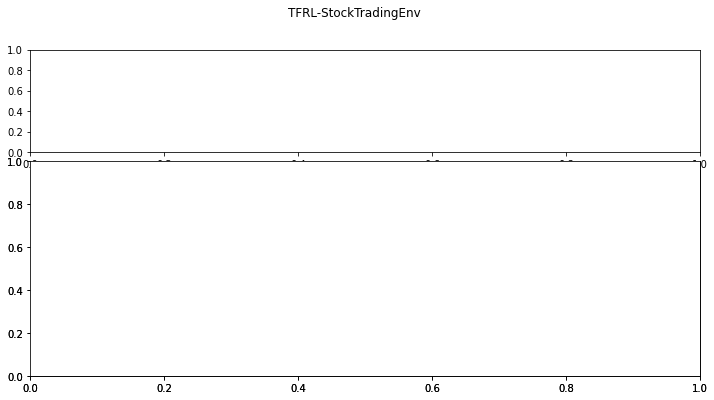

In [ ]:
if __name__ == "__main__":
    env = StockTradingContinuousEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()

### Visual stock/share trading environment with indicators & real data

In [ ]:
env_config = {
    "ticker": "TSLA",
    "opening_account_balance": 100000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "order_size": 1,  # Number of shares to buy per buy/sell order
    "data_dir": "/content"
}

In [ ]:
class StockTradingVisualEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Stock trading environment for RL agents
        The observations are stock price info (OHLCV) over a horizon as specified
        in env_config. Action space is discrete to perform buy/sell/hold trades.
        Args:
            ticker (str, optional): Ticker symbol for the stock. Defaults to "MSFT".
            env_config (Dict): Env configuration values
        """
        super(StockTradingVisualEnv, self).__init__()
        self.ticker = env_config.get("ticker", "MSFT")
        data_dir = env_config["data_dir"]
        self.ticker_file_stream = os.path.join(f"{data_dir}", f"{self.ticker}.csv")
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Historical stock data file stream not found at: data/{self.ticker}.csv"
        # Stock market data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        # Data-Frame: Date Open High Low Close Adj-Close Volume
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream)

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 0-> Hold; 1-> Buy; 2 ->Sell;
        self.action_space = spaces.Discrete(3)

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
        ]
        self.obs_width, self.obs_height = 128, 128
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(128, 128, 3),
            dtype=np.uint8,
        )
        self.order_size = env_config.get("order_size")
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the trading environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_shares_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-StockTradingVisualEnv",
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        """Return a view of the Ticker price chart as image observation

        Returns:
            img_observation (np.ndarray): Image of ticker candle stick plot
            with volume bars as observation
        """
        img_observation = self.viz.render_image_observation(
            self.current_step, self.horizon
        )
        img_observation = cv2.resize(
            img_observation, dsize=(128, 128), interpolation=cv2.INTER_CUBIC
        )

        return img_observation

    def execute_trade_action(self, action):
        if action == 0:  # Hold position
            return
        order_type = "buy" if action == 1 else "sell"

        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_shares = int(self.cash_balance / current_price)
            if allowable_shares < self.order_size:
                # Not enough cash to execute a buy order
                return
            # Simulate a BUY order and execute it at current_price
            num_shares_bought = self.order_size
            current_cost = self.cost_basis * self.num_shares_held
            additional_cost = num_shares_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_shares_held + num_shares_bought
            )
            self.num_shares_held += num_shares_bought

            self.trades.append(
                {
                    "type": "buy",
                    "step": self.current_step,
                    "shares": num_shares_bought,
                    "proceeds": additional_cost,
                }
            )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            if self.num_shares_held < self.order_size:
                # Not enough shares to execute a sell order
                return
            num_shares_sold = self.order_size
            self.cash_balance += num_shares_sold * current_price
            self.num_shares_held -= num_shares_sold
            sale_proceeds = num_shares_sold * current_price

            self.trades.append(
                {
                    "type": "sell",
                    "step": self.current_step,
                    "shares": num_shares_sold,
                    "proceeds": sale_proceeds,
                }
            )
        if self.num_shares_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_shares_held * current_price

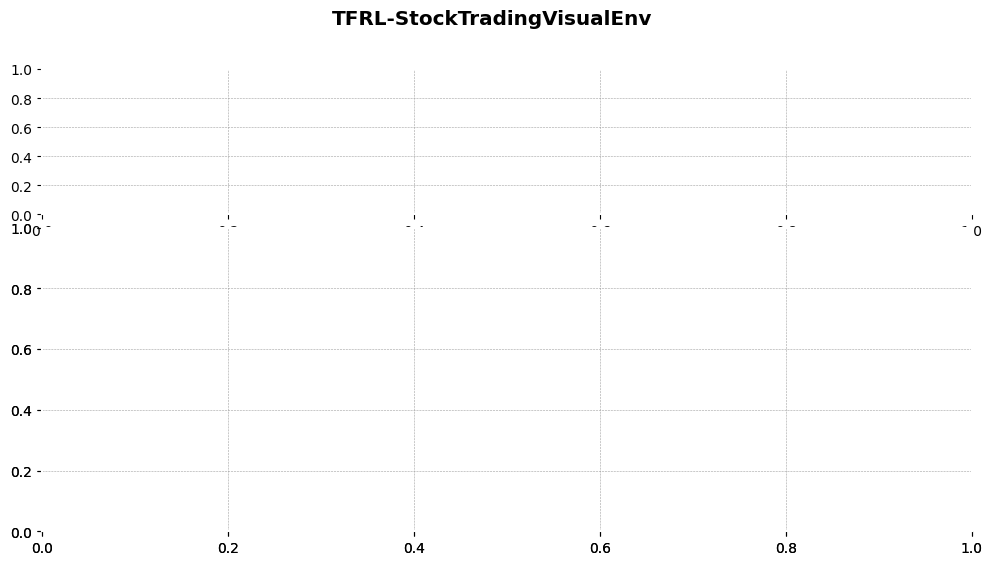

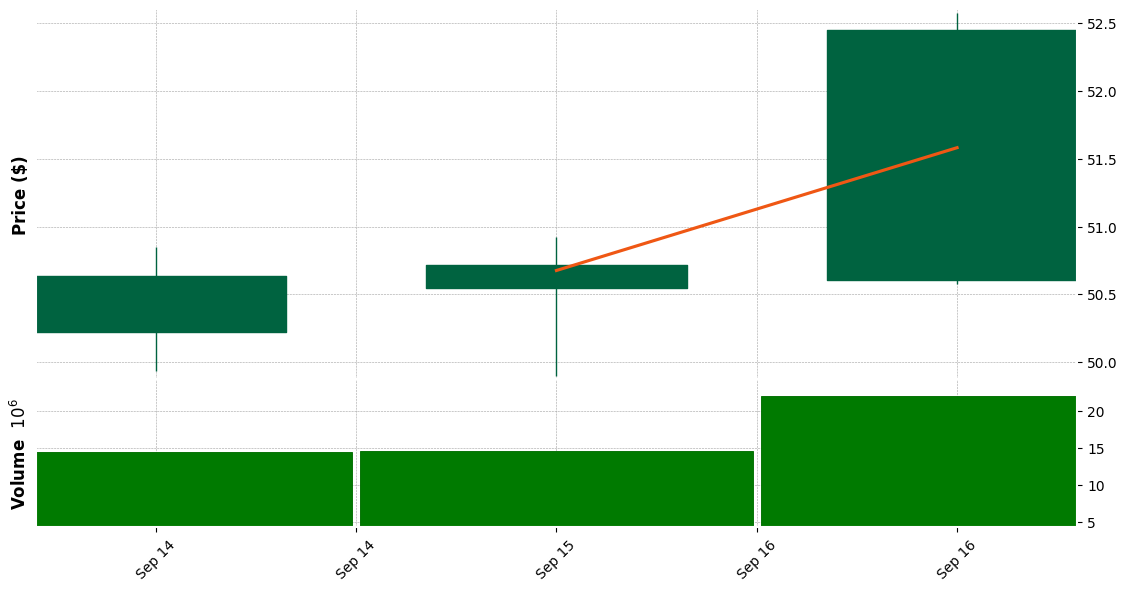

In [ ]:
if __name__ == "__main__":
    env = StockTradingVisualEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()

### Visual stock/share trading RL environment with continuous trade actions

In [ ]:
env_config = {
    "ticker": "MSFT",
    "opening_account_balance": 1000,
    # Number of steps (days) of data provided to the agent in one observation
    "observation_horizon_sequence_length": 30,
    "data_dir": "/content"
}

In [ ]:
class StockTradingVisualContinuousEnv(gym.Env):
    def __init__(self, env_config: Dict = env_config):
        """Stock trading environment for RL agents with continuous action space

        Args:
            ticker (str, optional): Ticker symbol for the stock. Defaults to "MSFT".
            env_config (Dict): Env configuration values
        """
        super(StockTradingVisualContinuousEnv, self).__init__()
        self.ticker = env_config.get("ticker", "MSFT")
        data_dir = env_config["data_dir"]
        self.ticker_file_stream = os.path.join(f"{data_dir}", f"{self.ticker}.csv")
        assert os.path.isfile(
            self.ticker_file_stream
        ), f"Historical stock data file stream not found at: data/{self.ticker}.csv"
        # Stock market data stream. An offline file stream is used. Alternatively, a web
        # API can be used to pull live data.
        # Data-Frame: Date Open High Low Close Adj-Close Volume
        self.ohlcv_df = pd.read_csv(self.ticker_file_stream)

        self.opening_account_balance = env_config["opening_account_balance"]
        # Action: 1-dim value indicating a fraction amount of shares to Buy (0 to 1) or
        # sell (-1 to 0). The fraction is taken on the allowable number of
        # shares that can be bought or sold based on the account balance (no margin).
        self.action_space = spaces.Box(
            low=np.array([-1]), high=np.array([1]), dtype=np.float
        )

        self.observation_features = [
            "Open",
            "High",
            "Low",
            "Close",
            "Adj Close",
            "Volume",
        ]
        self.obs_width, self.obs_height = 128, 128
        self.horizon = env_config.get("observation_horizon_sequence_length")
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(128, 128, 3),
            dtype=np.uint8,
        )
        self.viz = None  # Visualizer

    def step(self, action):
        # Execute one step within the environment
        self.execute_trade_action(action)

        self.current_step += 1

        reward = self.account_value - self.opening_account_balance  # Profit (loss)
        done = self.account_value <= 0 or self.current_step >= len(
            self.ohlcv_df.loc[:, "Open"].values
        )

        obs = self.get_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.cash_balance = self.opening_account_balance
        self.account_value = self.opening_account_balance
        self.num_shares_held = 0
        self.cost_basis = 0
        self.current_step = 0
        self.trades = []
        if self.viz is None:
            self.viz = TradeVisualizer(
                self.ticker,
                self.ticker_file_stream,
                "TFRL-StockTradingVisualContinuousEnv",
            )

        return self.get_observation()

    def render(self, **kwargs):
        # Render the environment to the screen

        if self.current_step > self.horizon:
            self.viz.render(
                self.current_step,
                self.account_value,
                self.trades,
                window_size=self.horizon,
            )

    def close(self):
        if self.viz is not None:
            self.viz.close()
            self.viz = None

    def get_observation(self):
        """Return a view of the Ticker price chart as image observation

        Returns:
            img_observation (np.ndarray): Image of ticker candle stick plot
            with volume bars as observation
        """
        img_observation = self.viz.render_image_observation(
            self.current_step, self.horizon
        )
        img_observation = cv2.resize(
            img_observation, dsize=(128, 128), interpolation=cv2.INTER_CUBIC
        )

        return img_observation

    def execute_trade_action(self, action):

        if action == 0:  # Indicates "Hold" action
            # Hold position; No trade to be executed
            return

        order_type = "buy" if action > 0 else "sell"

        order_fraction_of_allowable_shares = abs(action)
        # Stochastically determine the current stock price based on Market Open & Close
        current_price = random.uniform(
            self.ohlcv_df.loc[self.current_step, "Open"],
            self.ohlcv_df.loc[self.current_step, "Close"],
        )
        if order_type == "buy":
            allowable_shares = int(self.cash_balance / current_price)
            # Simulate a BUY order and execute it at current_price
            num_shares_bought = int(
                allowable_shares * order_fraction_of_allowable_shares
            )
            current_cost = self.cost_basis * self.num_shares_held
            additional_cost = num_shares_bought * current_price

            self.cash_balance -= additional_cost
            self.cost_basis = (current_cost + additional_cost) / (
                self.num_shares_held + num_shares_bought
            )
            self.num_shares_held += num_shares_bought

            if num_shares_bought > 0:
                self.trades.append(
                    {
                        "type": "buy",
                        "step": self.current_step,
                        "shares": num_shares_bought,
                        "proceeds": additional_cost,
                    }
                )

        elif order_type == "sell":
            # Simulate a SELL order and execute it at current_price
            num_shares_sold = int(
                self.num_shares_held * order_fraction_of_allowable_shares
            )
            self.cash_balance += num_shares_sold * current_price
            self.num_shares_held -= num_shares_sold
            sale_proceeds = num_shares_sold * current_price

            if num_shares_sold > 0:
                self.trades.append(
                    {
                        "type": "sell",
                        "step": self.current_step,
                        "shares": num_shares_sold,
                        "proceeds": sale_proceeds,
                    }
                )
        if self.num_shares_held == 0:
            self.cost_basis = 0
        # Update account value
        self.account_value = self.cash_balance + self.num_shares_held * current_price

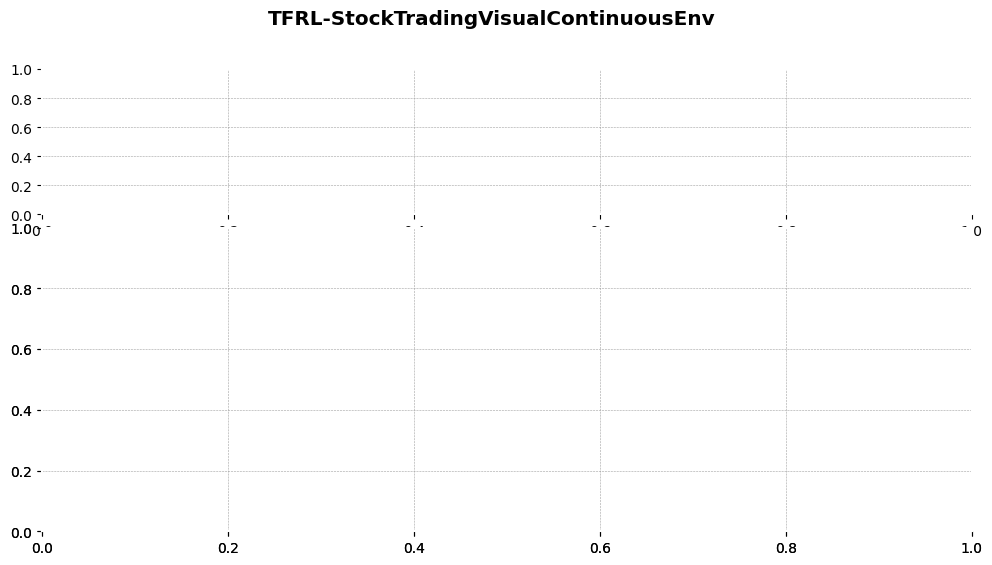

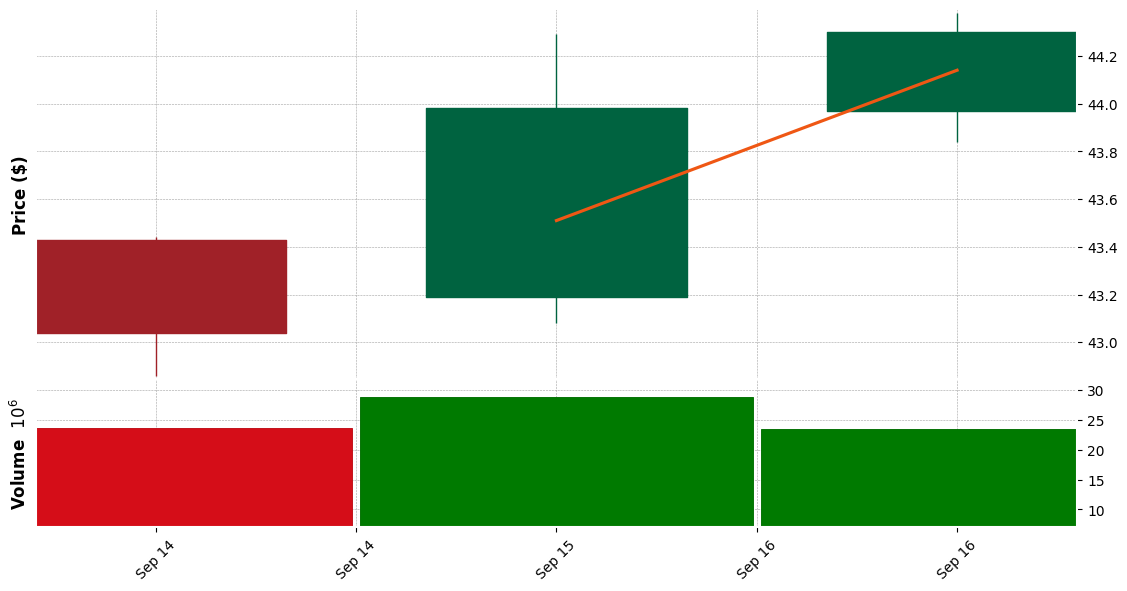

In [ ]:
if __name__ == "__main__":
    env = StockTradingVisualContinuousEnv()
    obs = env.reset()
    num_episodes = 2  # Increase num_episodes
    for _ in range(num_episodes):
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        env.render()

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-02 15:34:22

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.1.5
IPython   : 5.5.0
gym       : 0.17.3
numpy     : 1.19.5
mplfinance: 0.12.7a17
cv2       : 4.1.2
matplotlib: 3.2.2



---

**END**